# Basic Tutorial

Trey V. Wenger (c) February 2025

Here we demonstrate the basic features of a `bayes_spec` model.

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd

import pymc
print("pymc version:", pymc.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.20.0
bayes_spec version: 1.7.3-staging


## Model Definition

First, we define our model. Here we demonstrate a simple Gaussian line profile model where each "cloud" is a set of Gaussian parameters that produces one Gaussian emission line. See the definition of this model in `bayes_spec.models.GaussModel`, and check out the documentation for guidance on how to create `bayes_spec` models.

In [2]:
from bayes_spec.models import GaussModel

## Data Format

We wish to generate some synthetic data from our model, which requires us to take a brief aside to introduce the `bayes_spec` data format. We use the `SpecData` class to pass data into `bayes_spec`.

In [3]:
from bayes_spec import SpecData

# spectral axis definition
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 1.0 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(velocity_axis)) # K

# Our model only expects a single observation named "observation"
# Note that because we "named" the spectrum "observation" here,
# we must use the same name in the model definition above
observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

## Simulating Data

Now that we have a model definition and a dummy data format, we can generate simulated observations by drawing samples from the parameter prior distributions.

Sampling: [baseline_observation_norm, fwhm_norm, line_area_norm, observation, velocity_norm]


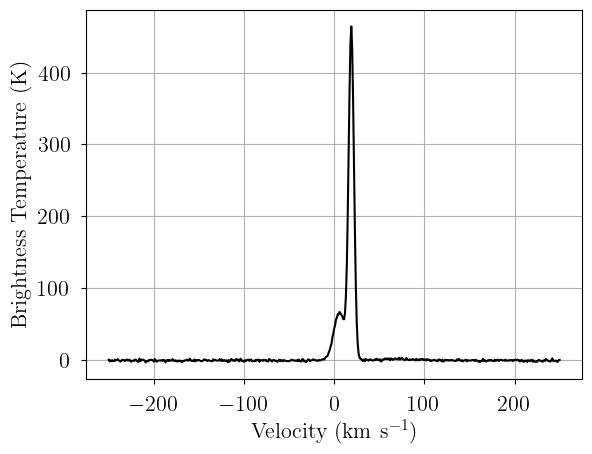

In [4]:
# Initialize and define the model
model = GaussModel(dummy_data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.add_priors(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
)
model.add_likelihood()

# Draw one posterior predictive sample
simulated = model.sample_prior_predictive(
    samples=1,
)
sim_brightness = simulated.prior_predictive["observation"].sel(chain=0, draw=0).data

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

Alternatively, we can pass the relevant parameters directly to the likelihood variable, named `observation` in our model, to evaluate a model with specific model parameters. Be sure that the simulated values are reasonable given your prior distributions!

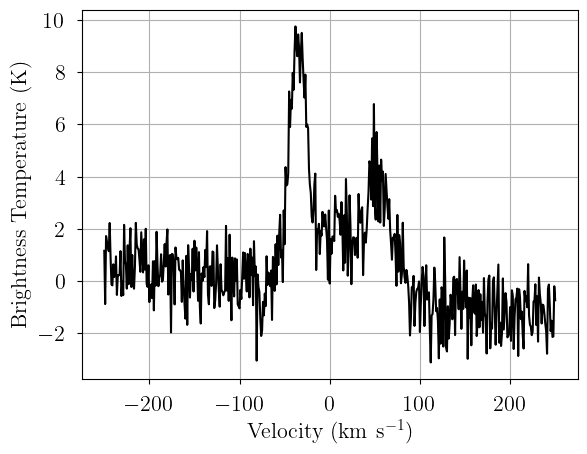

In [5]:
sim_brightness = model.model.observation.eval({
    "fwhm": [25.0, 40.0, 35.0], # FWHM line width (km/s)
    "line_area": [250.0, 125.0, 175.0], # line area (K km/s)
    "velocity": [-35.0, 10.0, 55.0], # velocity (km/s)
    "baseline_observation_norm": [-0.5, -2.0, 3.0], # normalized baseline coefficients
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [6]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## Model

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `bayes_spec`.

We begin with a three-cloud (`n_cloud=3`) model, with a 2nd order polynomial baseline (`baseline_degree=2`). Each "cloud" is a set of Gaussian parameters that produces a single Gaussian emission line. The length of `prior_baseline_coeffs` must be `baseline_degree + 1`, and generally can be left at the default value since the data and baseline are internally normalized.

In [10]:
model = GaussModel(data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.add_priors(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
)
model.add_likelihood()

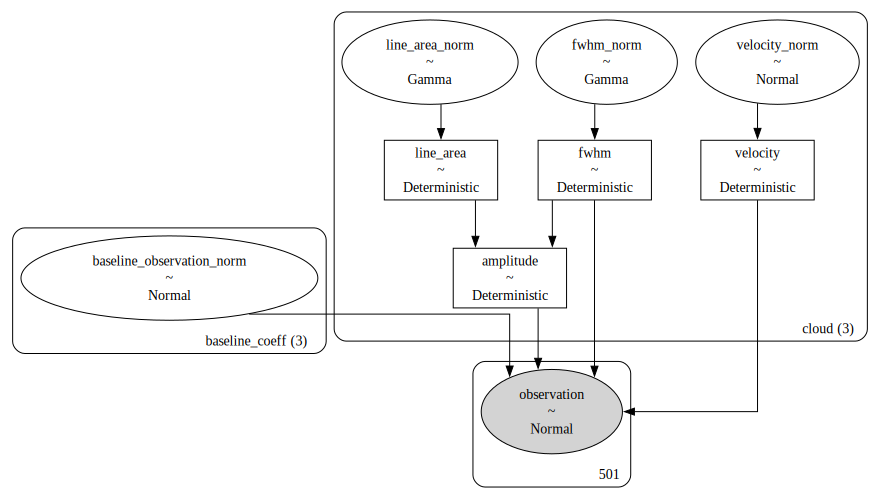

In [11]:
# Plot model graph
model.graph()

The model graph shows the relationship between the free parameters (ellipses), derived quantities (rectangles), and observed data (filled ellipses). Each "group" or "box" describes groups of parameters or values with a specific dimension: since `baseline_degree=2` then `baseline_coeff` has length 3, since `n_clouds=3` the number of clouds is 3, and there are 501 data points (channels) in our spectrum (observation).

In [12]:
# model string representation
print(model.model.str_repr())

baseline_observation_norm ~ Normal(0, <constant>)
           line_area_norm ~ Gamma(2, f())
                fwhm_norm ~ Gamma(2, f())
            velocity_norm ~ Normal(0, 1)
                line_area ~ Deterministic(f(line_area_norm))
                     fwhm ~ Deterministic(f(fwhm_norm))
                 velocity ~ Deterministic(f(velocity_norm))
                amplitude ~ Deterministic(f(fwhm_norm, line_area_norm))
              observation ~ Normal(f(fwhm_norm, line_area_norm, baseline_observation_norm, velocity_norm), <constant>)


We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [baseline_observation_norm, fwhm_norm, line_area_norm, observation, velocity_norm]


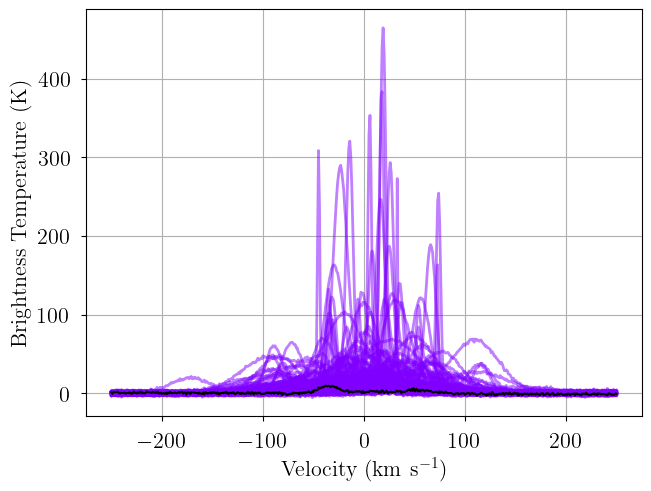

In [13]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

We can also generate a pair plot to inspect the prior distributions and their effect on deterministic quantities. The model has several attributes to access the various free parameters (`freeRVs`) and deterministic quantities (`deterministics`). Here we show the pair plot for the deterministic quantities derived from our prior distributions.

baseline_freeRVs ['baseline_observation_norm']
baseline_deterministics []
cloud_freeRVs ['line_area_norm', 'fwhm_norm', 'velocity_norm']
cloud_deterministics ['line_area', 'fwhm', 'velocity', 'amplitude']
hyper_freeRVs []
hyper_deterministics []


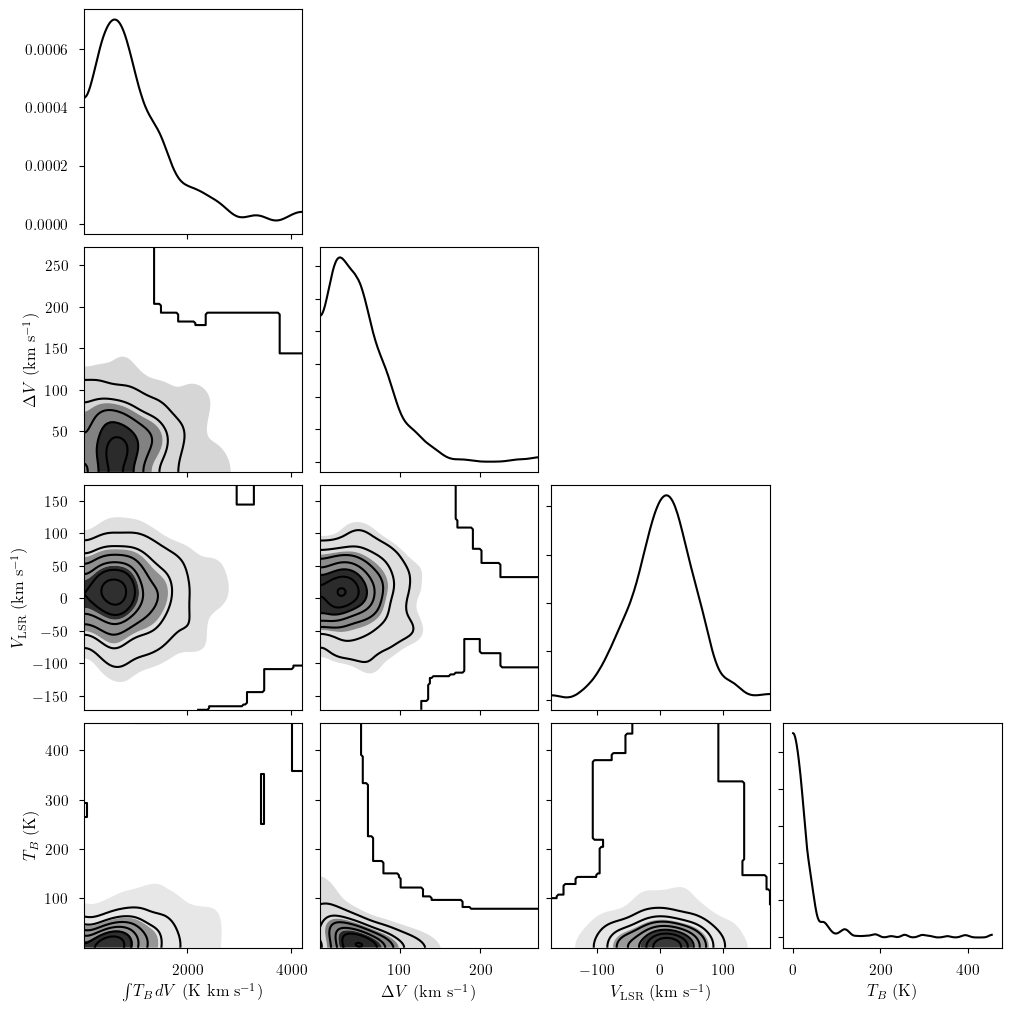

In [14]:
from bayes_spec.plots import plot_pair

# available parameter attributes:
print("baseline_freeRVs", model.baseline_freeRVs)
print("baseline_deterministics", model.baseline_deterministics)
print("cloud_freeRVs", model.cloud_freeRVs)
print("cloud_deterministics", model.cloud_deterministics)
print("hyper_freeRVs", model.hyper_freeRVs)
print("hyper_deterministics", model.hyper_deterministics)

var_names = model.cloud_deterministics
_ = plot_pair(
    prior.prior, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

## Posterior Sampling: Variational Inference

We can approximate the posterior distribution using variational inference (VI). We will run a maximum of `n` iterations, but stop early if it appears that VI has converged on a solution. You will have to tune the convergence thresholds and learning rate for your model.

In [15]:
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.05, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)

Output()

Convergence achieved at 4100
Interrupted at 4,099 [4%]: Average Loss = 3,526


Output()

In [16]:
# posterior samples stored in model.trace.posterior
az.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_observation_norm[0],-0.558,0.051,-0.652,-0.464,0.002,0.001,1007.0,981.0,NaN
baseline_observation_norm[1],-1.927,0.171,-2.221,-1.568,0.006,0.004,816.0,952.0,NaN
baseline_observation_norm[2],0.382,0.758,-0.940,1.762,0.025,0.017,945.0,981.0,NaN
velocity_norm[0],-0.705,0.008,-0.720,-0.689,0.000,0.000,1082.0,944.0,NaN
velocity_norm[1],1.122,0.023,1.078,1.162,0.001,0.000,1124.0,996.0,NaN
velocity_norm[2],0.141,0.057,0.036,0.245,0.002,0.001,883.0,820.0,NaN
line_area_norm[0],0.412,0.013,0.387,0.434,0.000,0.000,964.0,837.0,NaN
line_area_norm[1],0.270,0.016,0.244,0.301,0.001,0.000,884.0,690.0,NaN
line_area_norm[2],0.331,0.022,0.291,0.374,0.001,0.001,773.0,524.0,NaN
fwhm_norm[0],0.884,0.033,0.819,0.945,0.001,0.001,991.0,920.0,NaN


It's good practice to verify the integrity of your solution! Here we generate posterior predictive checks -- realizations of the model drawn with parameters drawn from the posterior distribution. Each line is one posterior sample.

Sampling: [observation]


Output()

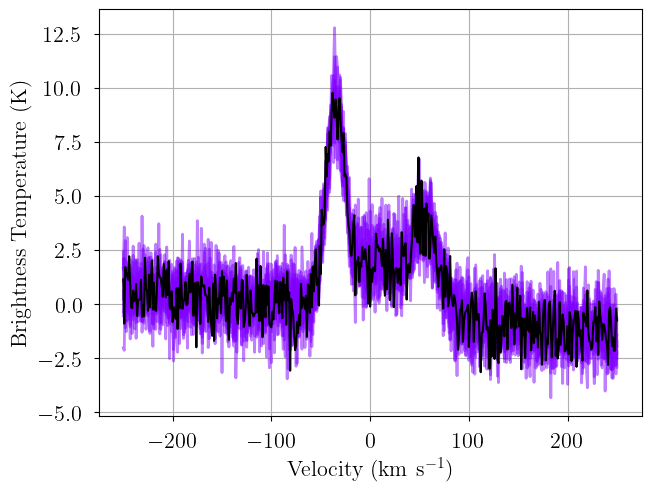

In [17]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

VI is fast, but it's not particularly accurate, and there is no way to diagnose "convergence". Instead, we sample the posterior distribution using MCMC. Here we initialize the No U-Turn Sampler (NUTS) using VI (also available is the `pymc` default: `init="jitter+adapt_diag"`, which may be better suited to some models). We can customize the VI initialization as well as the NUTS parameters. If there are many divergences, or if the resulting effective sample sizes are small and `r_hat` is large, try increasing the number of tuning samples, draws, and/or chains. Increasing `target_accept` to `0.9` or `0.95` can help if there are many divergences. Use as many chains as possible.

In [18]:
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.05, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 4100
Interrupted at 4,099 [4%]: Average Loss = 3,526
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, line_area_norm, fwhm_norm, velocity_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


Adding log-likelihood to trace


Output()

If a chain does not converge, an error is printed and that chain is dropped from all subsequent analyses. In the remaining chains, there may be some divergences. The number of divergences should be much less than the number of posterior samples.

In general, there could be a labeling degeneracy, or multiple unique solutions. Here we "solve" for those effects using a Gaussian Mixture Model (GMM). The parameter `kl_div_threshold` defines the probability threshold for "unique" GMM solutions.

In [19]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [20]:
print("solutions:", model.solutions)
display(az.summary(model.trace["solution_0"]))
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_observation_norm[0],-0.588,0.072,-0.717,-0.447,0.001,0.001,2936.0,2798.0,1.0
baseline_observation_norm[1],-1.983,0.153,-2.258,-1.692,0.002,0.002,4318.0,3017.0,1.0
baseline_observation_norm[2],0.421,0.900,-1.267,2.067,0.016,0.013,3202.0,2971.0,1.0
velocity_norm[0],-0.705,0.009,-0.722,-0.687,0.000,0.000,2441.0,2572.0,1.0
velocity_norm[1],1.096,0.030,1.039,1.151,0.001,0.000,1927.0,2924.0,1.0
velocity_norm[2],0.140,0.105,-0.054,0.357,0.003,0.002,1378.0,1437.0,1.0
line_area_norm[0],0.434,0.036,0.367,0.497,0.001,0.001,1190.0,2223.0,1.0
line_area_norm[1],0.298,0.053,0.196,0.393,0.002,0.001,1004.0,1290.0,1.0
line_area_norm[2],0.287,0.080,0.160,0.442,0.003,0.002,949.0,1921.0,1.0
fwhm_norm[0],0.908,0.051,0.811,1.000,0.001,0.001,1749.0,2616.0,1.0


We again generate posterior predictive checks as well as a trace plot of the individual chains. Each line is one posterior sample.

Sampling: [observation]


Output()

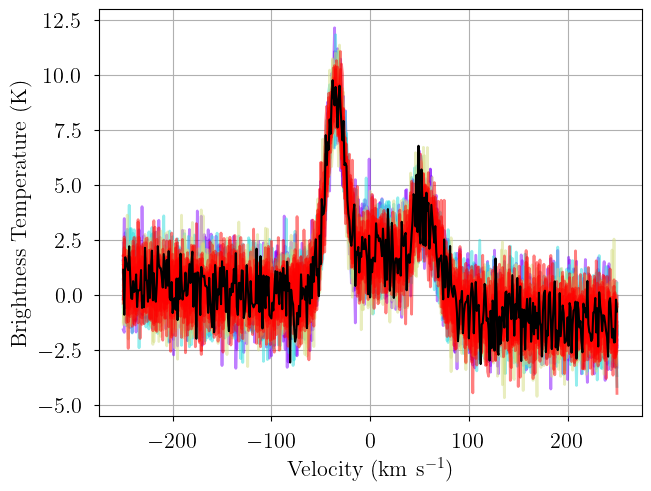

In [21]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

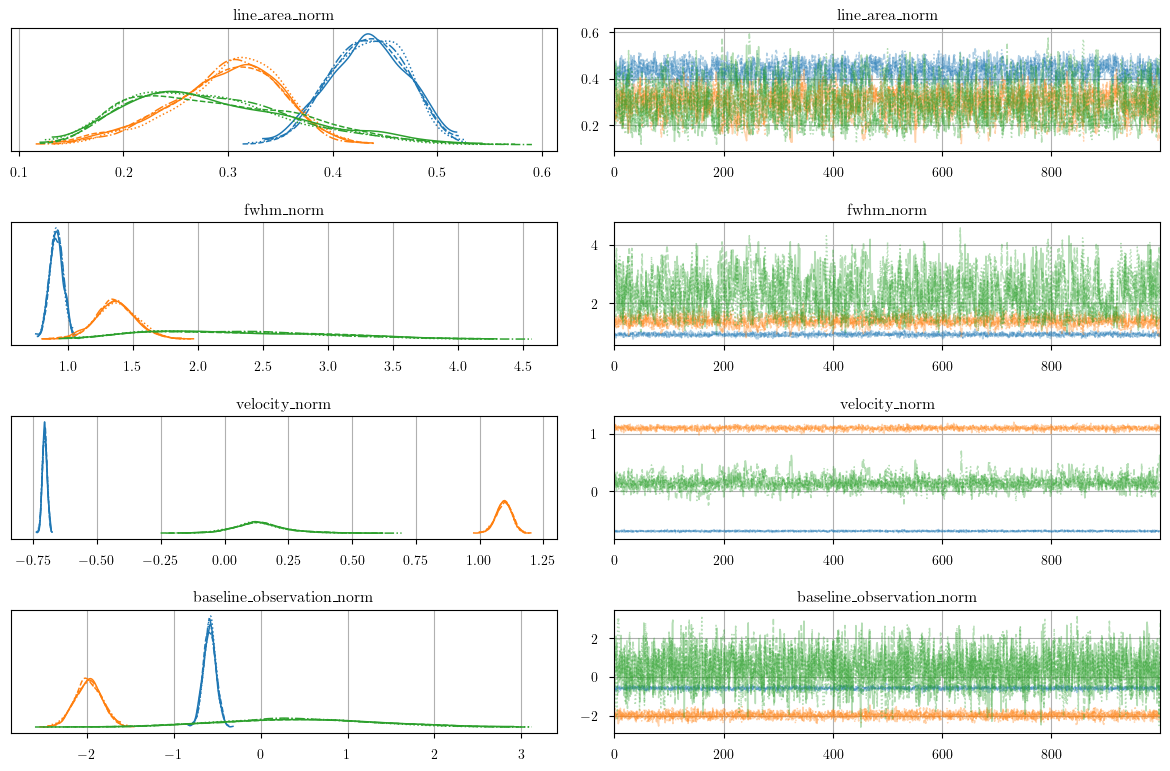

In [27]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

In these trace plots, each linestyle represents a different Markov chain (there are four different chains and linestyles), and each color represents a different parameter group. For example, there are three colors for `line_area_norm` representing the three clouds of the model, and there are three colors for `baseline_observation_norm` representing the three baseline coefficients (since `baseline_degree=2` there are three polynomial baseline coefficients).

We can inspect the posterior distribution pair plots. First, the (deterministic) cloud parameters.

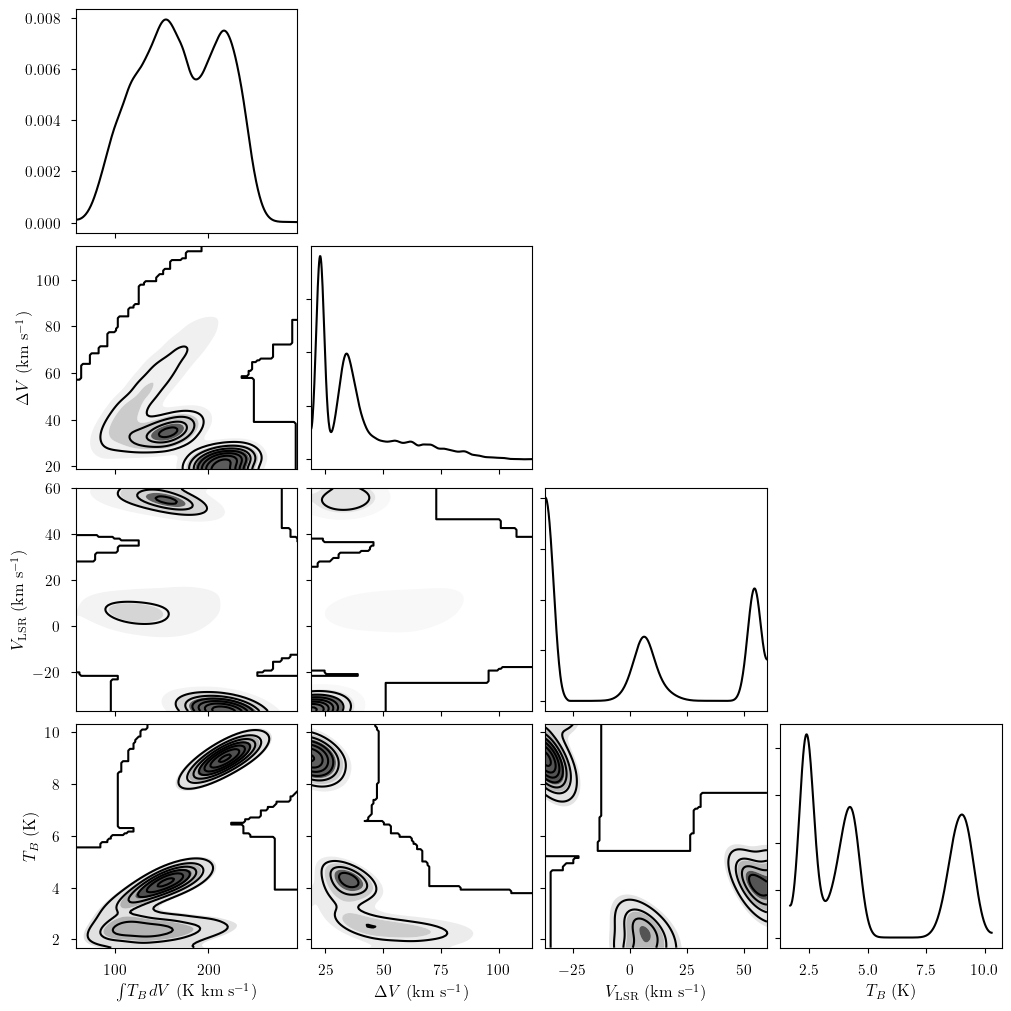

In [23]:
_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions for a single cloud.

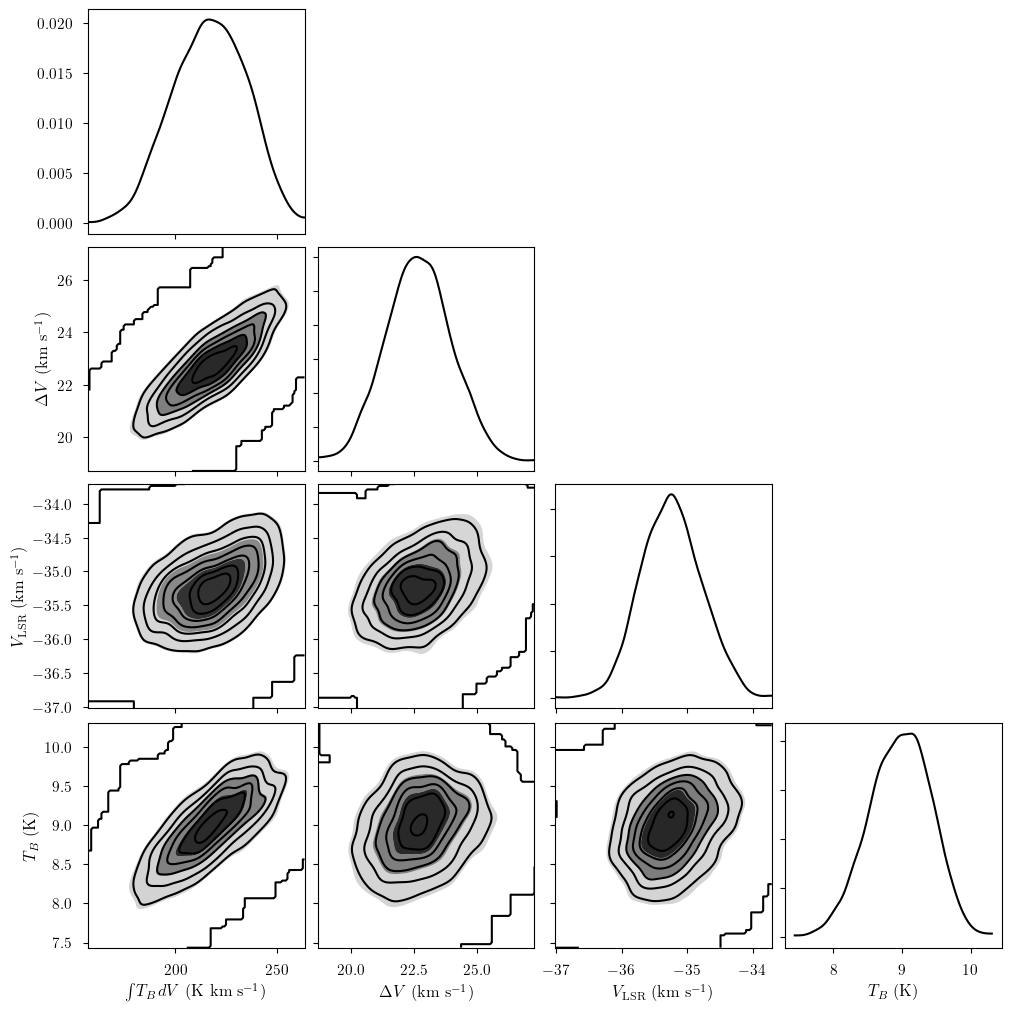

In [28]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [25]:
point_stats = az.summary(model.trace.solution_0, var_names=model.cloud_deterministics, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
point_stats

BIC: 1435.0145195075604


,mean,sd,hdi_16%,hdi_84%
line_area[0],216.800,17.913,200.598,237.810
line_area[1],148.964,26.278,127.682,177.905
line_area[2],143.555,39.957,90.347,167.527
fwhm[0],22.700,1.276,21.464,24.023
fwhm[1],34.225,3.926,29.927,37.425
fwhm[2],57.134,16.809,35.495,69.733
velocity[0],-35.240,0.461,-35.751,-34.830
velocity[1],54.792,1.488,53.339,56.264
velocity[2],6.982,5.272,1.337,10.722
amplitude[0],8.967,0.448,8.555,9.452
